<a href="https://colab.research.google.com/github/haldonmez/mnist-digit-recognizer/blob/main/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torch import nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(f"Pytorch version: {torch.__version__}\ntorchvision version:{torchvision.__version__}")

Pytorch version: 2.2.1+cu121
torchvision version:0.17.1+cu121


In [4]:
data = "/content/data"
train_data = datasets.MNIST(
    root=data,
    train= True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = datasets.MNIST(
    root=data,
    train=False,
    transform=ToTensor(),
    download=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 48443158.76it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30021237.63it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19744401.90it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5874353.61it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [5]:
import numpy as np
def threshold_image(im,th):
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1
    return thresholded_im

This is normaltorch.float32
This is otsutorch.float32


Text(0.5, 1.0, '1')

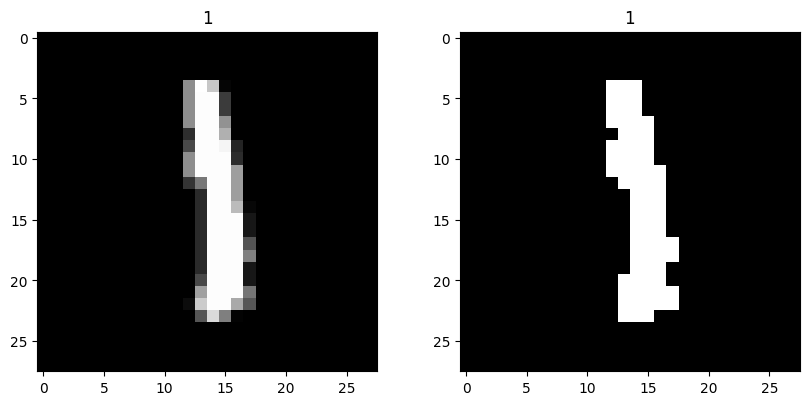

In [6]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
import random

train_dataset_path = '/content/data/MNIST/train-dataset.pt'
test_dataset_path = '/content/data/MNIST/test-dataset.pt'

if not os.path.exists(train_dataset_path and test_dataset_path):
  train_data_otsu2 = [(torch.tensor(threshold_image(image[0], 0.2611499991255095)).unsqueeze(0).float(), label) for image, label in train_data]
  torch.save(train_data_otsu2, train_dataset_path)
  test_data_otsu2 = [(torch.tensor(threshold_image(image[0], 0.2611499991255095)).unsqueeze(0).float(), label) for image, label in test_data]
  torch.save(train_data_otsu2, test_dataset_path)
else:
    # If the dataset already exists, load it
    train_data_otsu2 = torch.load(train_dataset_path)
    test_data_otsu2 = torch.load(test_dataset_path)

random_number = random.randint(0,len(train_data_otsu2))
image, label = train_data[random_number]
image2, label2 = train_data_otsu2[random_number]
image2.shape, image.shape
print(f"This is normal{train_data[0][0].dtype}")
print(f"This is otsu{train_data_otsu2[0][0].dtype}")
plt.figure(figsize=(10,15))
plt.subplot(321); plt.imshow(image.squeeze(),cmap='gray')
plt.title(label)
plt.subplot(322); plt.imshow(image2.squeeze(),cmap='gray')
plt.title(label2)

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

combined_train_data = ConcatDataset([train_data_otsu2, train_data])
combined_test_data = ConcatDataset([test_data_otsu2, test_data])
BATCH_SIZE = 32
train_dataloader = DataLoader(combined_train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 3750 iterations with the batch size of 32.
For testing data there is 313 iterations with the batch size of 32.


In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
class_names = train_data.classes

In [10]:
# Create a convolutional neural network
class DigitRecognizerMNISTV3(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_3 = DigitRecognizerMNISTV3(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_3

DigitRecognizerMNISTV3(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                             lr=0.01)

In [16]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [17]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [18]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [ ]:
torch.manual_seed(42)
from tqdm.auto import tqdm
# Measure time
from timeit import default_timer as timer
train_time_start_model_3 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_3,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_3,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_3 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_3,
                                           end=train_time_end_model_3,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (100,) and (19,)

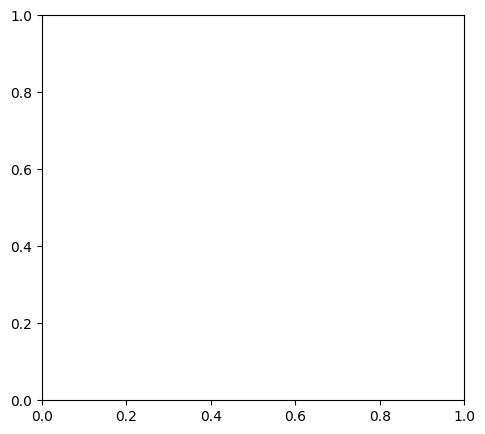

In [20]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The last version of traning with lr:0.01 ==> Train loss is:0.01870, Train accuracy is:99.38%
Test loss is:0.01427, Test accuracy is:99.55%
Epoch: 49

The last version of traning with lr:0.01 ==> Train loss is:0.00743, Train accuracy is:99.77%
Test loss is:0.005525, Test accuracy is:99.803333%
Epoch: 99
---------
